In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("figure", figsize=(12.0, 8.0))
import seaborn as sns
sns.set(color_codes=True)

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Data Input

In [2]:
conn = sqlite3.connect("salaries.db")
columns = ["File_Date",
           "SubAgency", 
           "Age_Range",
           "Education_Level",
           "Pay_Plan",
           "Grade",
           "LOS_Level",
           "Occupation",
           "PATCO",
           "Adjusted_Basic_Pay",
           "Supervisory_Status",
           "TOA",
           "Work_Schedule",
           "NSFTP_Indicator"]

In [3]:
num_employees = pd.read_sql_query("""
SELECT 
    File_Date AS Date, 
    Occupation,
    COUNT(*) AS Number_Employees 
FROM 
    (SELECT
        File_Date,
        REPLACE(Occupation, '1169', '0512') AS Occupation
     FROM 
         data) sub
WHERE
    File_Date LIKE '%03'
    AND Occupation IN ('0512')
GROUP BY
    File_Date,
    Occupation
;""", conn)
num_employees["Date"] = pd.to_datetime(num_employees["Date"], format="%Y%m")
num_employees["Occupation"] = num_employees["Occupation"].map({"0512": "Internal Revenue Service"})

In [4]:
total_salaries = pd.read_sql_query("""
SELECT 
    File_Date AS Date, 
    REPLACE(Occupation, "1169", "0512") AS Occupation,
    SUM(Adjusted_Basic_Pay) AS Total_Budget 
FROM 
    (SELECT
        File_Date,
        REPLACE(Occupation, '1169', '0512') AS Occupation,
        Adjusted_Basic_Pay
     FROM 
         data) sub
WHERE
    File_Date LIKE '%03'
    AND Occupation IN ('0512')
GROUP BY
    File_Date, 
    Occupation
;""", conn)
total_salaries["Date"] = pd.to_datetime(total_salaries["Date"], format="%Y%m")
total_salaries["Occupation"] = total_salaries["Occupation"].map({"0512": "Internal Revenue Service"})

In [5]:
average_salaries = pd.read_sql_query("""
SELECT 
    File_Date AS Date, 
    Occupation,
    AVG(Adjusted_Basic_Pay) AS Average_Salary
FROM 
    (SELECT
        File_Date,
        REPLACE(Occupation, '1169', '0512') AS Occupation,
        Adjusted_Basic_Pay
     FROM 
         data) sub
WHERE
    File_Date LIKE '%03'
    AND Occupation IN ('0512')
GROUP BY
    File_Date, 
    Occupation
;""", conn)
average_salaries["Date"] = pd.to_datetime(average_salaries["Date"], format="%Y%m")
average_salaries["Occupation"] = average_salaries["Occupation"].map({"0512": "Internal Revenue Service"})

In [41]:
IRS = pd.read_csv("IRS_data_summary.csv", thousands=",")
IRS.set_index("Year", inplace=True)
IRS.sort_index(inplace=True)
IRS["Individual exam coverage"] = (IRS["Individual returns examined"] / IRS["Individual returns filed"])
IRS["Corporate exam coverage"] = (IRS["Corporate returns examined"] / IRS["Corporate returns filed"])
IRS["Total additional tax"] = (IRS["Individual additional tax"] + IRS["Corporate additional tax"])

# IRS employee count each year from 1998-2016
recent_IRS_employee_counts = num_employees[(num_employees["Date"] > "1998-01-01") & (num_employees["Date"] < "2017-01-01")]["Number_Employees"].as_matrix().reshape(-1, 1)

IRS["Individual exams per employee"] = (IRS["Individual returns examined"] / recent_IRS_employee_counts.ravel())
IRS["Corporate exams per employee"] = (IRS["Corporate returns examined"] / recent_IRS_employee_counts.ravel())

IRS["Individual additional tax per employee"] = (IRS["Individual additional tax"] / recent_IRS_employee_counts.ravel())
IRS["Corporate additional tax per employee"] = (IRS["Corporate additional tax"] / recent_IRS_employee_counts.ravel())
IRS["Total additional tax per employee"] = (IRS["Total additional tax"] / recent_IRS_employee_counts.ravel())

# Plots

### Exam Coverage

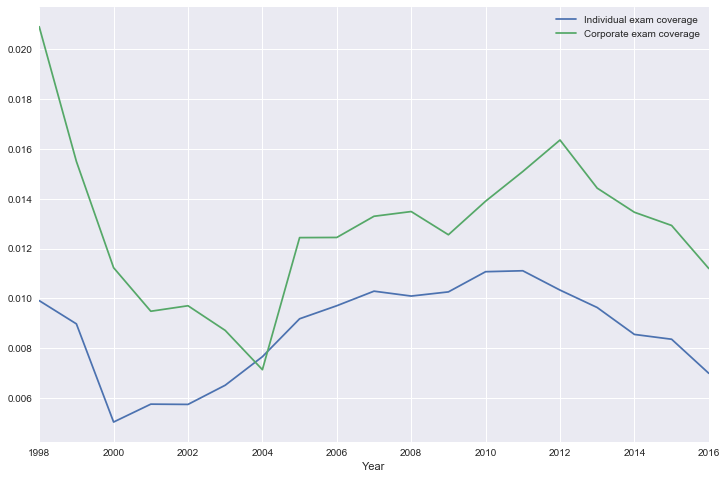

In [42]:
IRS[["Individual exam coverage", "Corporate exam coverage"]].plot()

### Additional Taxes Recovered

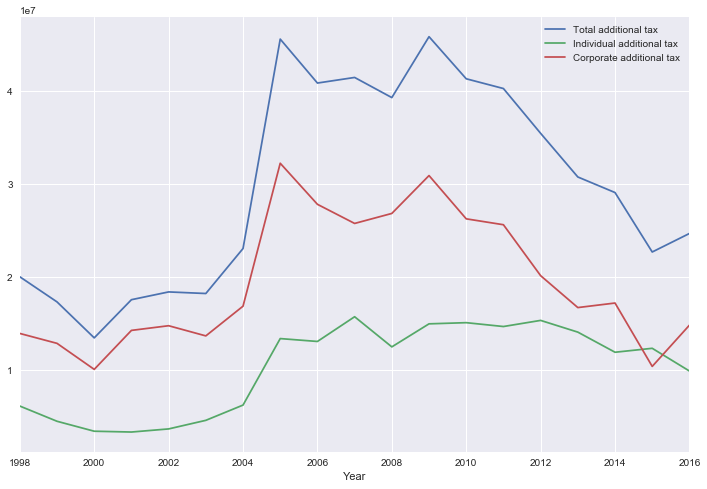

In [43]:
IRS[["Total additional tax", "Individual additional tax", "Corporate additional tax"]].plot()

### Exams Per Employee

      Individual exams per employee  Corporate exams per employee
Year                                                             
1998                      55.047997                      2.494508
1999                      52.953749                      1.881750
2000                      34.490989                      1.418798
2001                      39.181623                      1.245877
2002                      40.292547                      1.268010
2003                      46.831872                      1.158258
2004                      54.872207                      0.940947
2005                      64.995392                      1.570794
2006                      69.189524                      1.551921
2007                      73.447722                      1.591640
2008                      74.989546                      1.639112
2009                      77.947193                      1.540917
2010                      76.595660                      1.443524
2011      

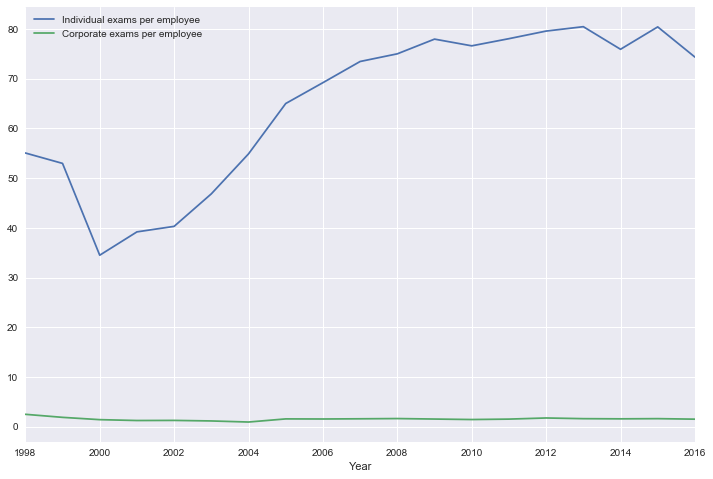

In [44]:
print(IRS[["Individual exams per employee", "Corporate exams per employee"]])
IRS[["Individual exams per employee", "Corporate exams per employee"]].plot()

### Additional Taxes Recovered Per Employee

Year
1998     923.135176
1999     832.601935
2000     676.171164
2001     939.043211
2002     995.280414
2003    1003.795092
2004    1268.171491
2005    2470.272387
2006    2201.027375
2007    2198.644210
2008    2116.745810
2009    2505.466299
2010    2000.559915
2011    2007.618573
2012    1902.459358
2013    1760.222171
2014    1775.580426
2015    1484.240932
2016    1771.280543
Name: Total additional tax per employee, dtype: float64


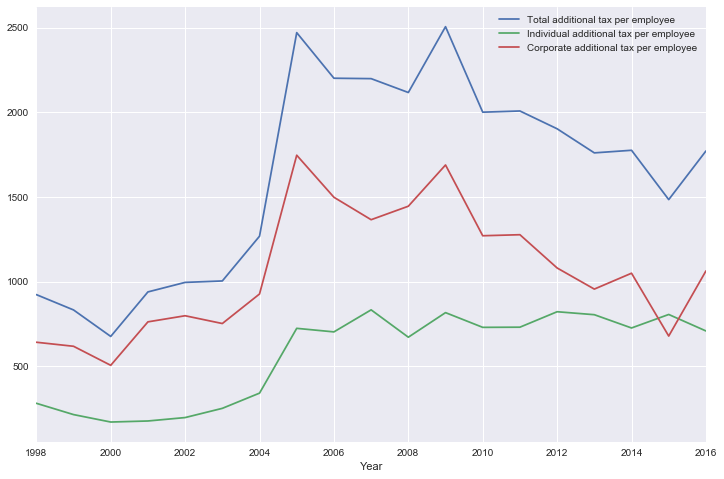

In [45]:
print(IRS["Total additional tax per employee"])
IRS[["Total additional tax per employee", "Individual additional tax per employee", "Corporate additional tax per employee"]].plot()

# IRS Performance Regressions

Some helper code for fitting and plotting linear models:

In [46]:
def linear_regression(X, y, year_limit=None):
    """
    Given n-dimensional vectors X and y, fits a least-squares linear model.
    If year_limit is specified, the model uses only the last year_limit years of data.
    """
    # Only use data from the past year_limit years
    if year_limit:
        X = X[-year_limit:]
        y = y[-year_limit:]
    
    # Create linear regression model
    model = linear_model.LinearRegression()

    # Fit the model
    model.fit(X, y)

    # Make in-sample predictions
    y_predicted = model.predict(X)

    # Show parameters of the model
    print('Slope:\t\t', model.coef_[0])
    print('Intercept:\t', model.intercept_)

    # Mean squared error
    print("Mean squared error:\t%.2f" % mean_squared_error(y, y_predicted))

    # Explained variance score (1 is perfect prediction)
    print('Variance/R^2 score:\t%.2f' % r2_score(y, y_predicted))

    # Plot data points and fitted line
    plt.scatter(X, y, color='black')
    plt.plot(X, y_predicted, color='blue', linewidth=3)

### Head Count vs. Number of Exams

Indidividual taxes:

Slope:		 80.2162229884
Intercept:	 -39451.9330429
Mean squared error:	1209263148.78
Variance/R^2 score:	0.97


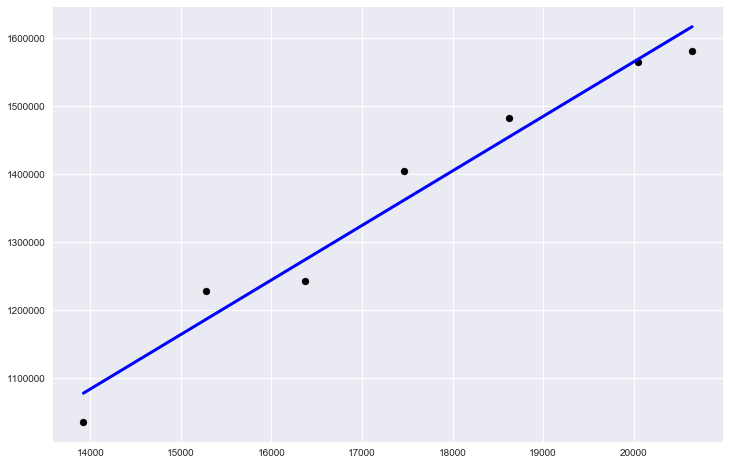

In [60]:
# IRS employee count each year
X = recent_IRS_employee_counts

# Percent of returns audited each year
y = IRS["Individual returns examined"].as_matrix()

# Fit a linear model using only 2010-2016 data
linear_regression(X, y, year_limit=7)

Corporate taxes:

Slope:		 1.4119429644
Intercept:	 2920.93463949
Mean squared error:	2885395.54
Variance/R^2 score:	0.78


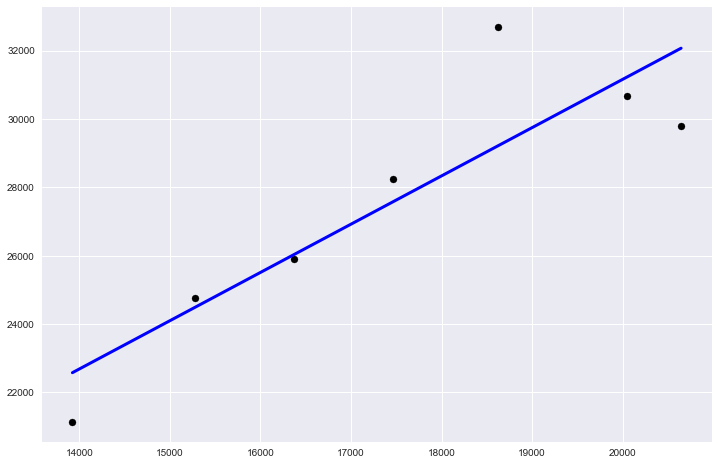

In [61]:
# IRS employee count each year
X = recent_IRS_employee_counts

# Percent of returns audited each year
y = IRS["Corporate returns examined"].as_matrix()

# Fit a linear model using only 2010-2016 data
linear_regression(X, y, year_limit=7)

### Head Count vs. Exam Coverage

Indidividual taxes:

Slope:		 6.14238046937e-07
Intercept:	 -0.00129864916056
Mean squared error:	0.00
Variance/R^2 score:	0.97


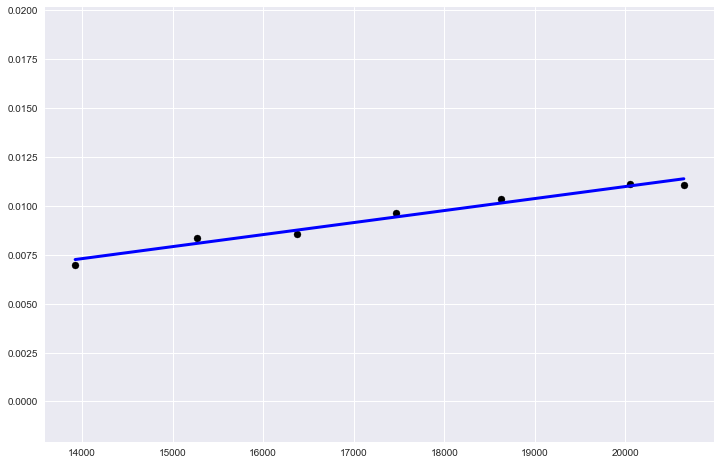

In [51]:
# IRS employee count each year
X = recent_IRS_employee_counts

# Percent of returns audited each year
y = IRS["Individual exam coverage"].as_matrix()

# Fit a linear model using only 2010-2016 data
linear_regression(X, y, year_limit=7)

Corporate taxes:

Slope:		 4.93707400748e-07
Intercept:	 0.00527954262183
Mean squared error:	0.00
Variance/R^2 score:	0.55


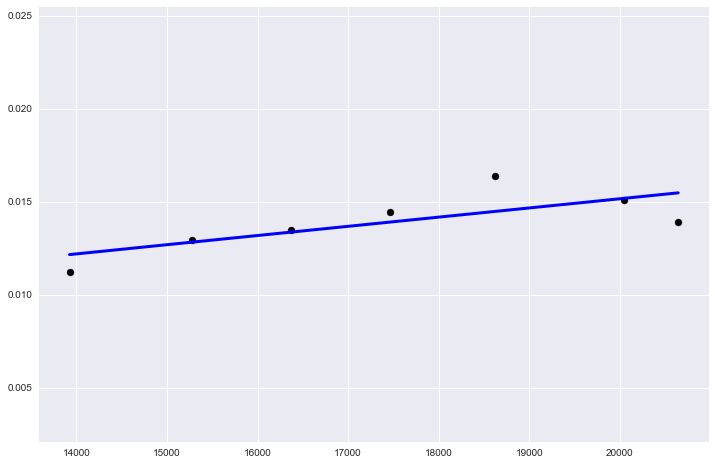

In [52]:
# IRS employee count each year
X = recent_IRS_employee_counts

# Percent of returns audited each year
y = IRS["Corporate exam coverage"].as_matrix()

# Fit a linear model using only 2010-2016 data
linear_regression(X, y, year_limit=7)

### Head Count vs. Recovered Taxes

Individual taxes:

Slope:		 744.970871577
Intercept:	 284038.99284
Mean squared error:	567513822723.44
Variance/R^2 score:	0.84


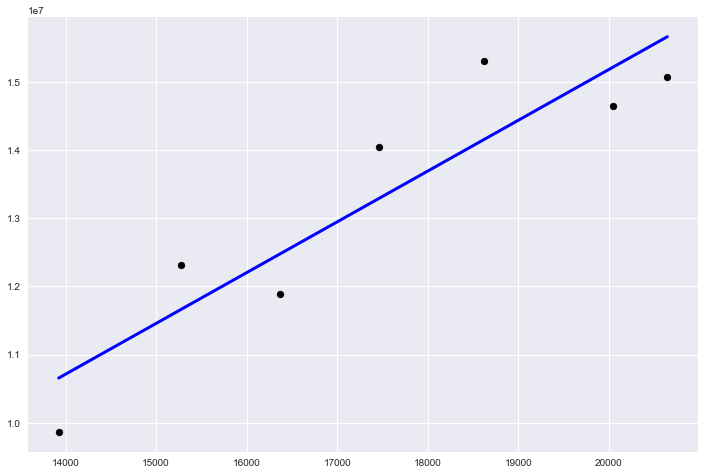

In [53]:
# IRS employee count each year
X = recent_IRS_employee_counts

# Tax dollars recovered each year
y = IRS["Individual additional tax"].as_matrix()

# Fit a linear model using only 2010-2016 data
linear_regression(X, y, year_limit=7)

Corporate taxes:

Slope:		 2104.6261464
Intercept:	 -18073522.5557
Mean squared error:	5003577971125.47
Variance/R^2 score:	0.82


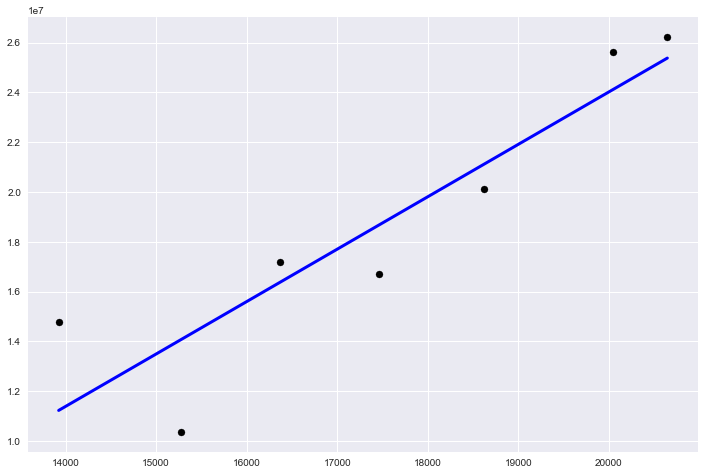

In [54]:
# IRS employee count each year
X = recent_IRS_employee_counts

# Tax dollars recovered each year
y = IRS["Corporate additional tax"].as_matrix()

# Fit a linear model using only 2010-2016 data
linear_regression(X, y, year_limit=7)

Total taxes:

Slope:		 2849.59701798
Intercept:	 -17789483.5629
Mean squared error:	2797524993265.65
Variance/R^2 score:	0.94


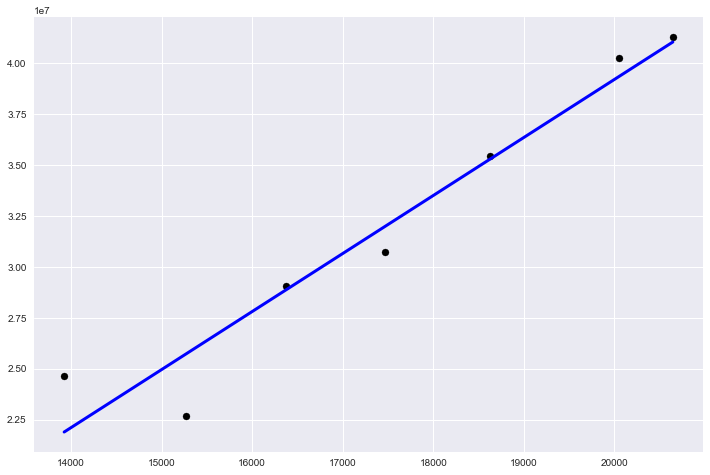

In [55]:
# IRS employee count each year
X = recent_IRS_employee_counts

# Tax dollars recovered each year
y = IRS["Total additional tax"].as_matrix()

# Fit a linear model using only 2010-2016 data
linear_regression(X, y, year_limit=7)

# Data Exploration

In [56]:
num_employees[(num_employees["Date"] > "1998-01-01") & (num_employees["Date"] < "2017-01-01")]["Number_Employees"]

24    21668
25    20778
26    19864
27    18676
28    18462
29    18135
30    18170
31    18448
32    18557
33    18851
34    18557
35    18293
36    20646
37    20051
38    18626
39    17464
40    16369
41    15274
42    13923
Name: Number_Employees, dtype: int64

In [58]:
IRS["Individual exam coverage"]

Year
1998    0.009912
1999    0.008978
2000    0.005040
2001    0.005757
2002    0.005747
2003    0.006516
2004    0.007662
2005    0.009183
2006    0.009707
2007    0.010291
2008    0.010095
2009    0.010262
2010    0.011072
2011    0.011110
2012    0.010335
2013    0.009635
2014    0.008555
2015    0.008362
2016    0.006994
Name: Individual exam coverage, dtype: float64

In [59]:
IRS["Individual additional tax"]

Year
1998     6095698
1999     4458474
2000     3388905
2001     3301860
2002     3636486
2003     4559902
2004     6201693
2005    13355087
2006    13045221
2007    15705155
2008    12462770
2009    14940892
2010    15066486
2011    14652239
2012    15310908
2013    14049657
2014    11885411
2015    12308319
2016     9864674
Name: Individual additional tax, dtype: int64

In [21]:
# conn.close()